In [1]:
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import scanpy as sc

import sys
sys.path.append("../../lib")
from stpalette import palette1
from cheatmap import cplot
# from utils_lineage import plotTree
from utils import loadCNVfromCaSpER, loadCNVfromInferCNV
from stpalette import palette1
from plots import plotSpatialAll

In [2]:
model = 'WM4237'

dataPath = '../../data/'
preprocessedCasperCNVDataPath = 'c:/Projects/A_ST/output_casper_%s/' % model
preprocessedInferCNVDataPath = 'c:/Projects/A_ST/inferCNV_results_%s/' % model

ids = sorted(np.loadtxt(dataPath + 'ids_%s_ST.txt' % model, dtype=str))
sids = [id[7:12] for id in ids]

palette1.update({sid: cm.terrain(0.01 + i/len(sids)) for i, sid in enumerate(sids)})

In [3]:
df_infercnv_cnv, df_infercnv_meta = loadCNVfromInferCNV(dataPath + 'For_inferCNV_%s_meta.data.tsv.gz' % model, 
                                                        [preprocessedInferCNVDataPath + 'infercnv.references.txt',
                                                         preprocessedInferCNVDataPath + 'infercnv.observations.txt'])

(8897, 18397) (18397, 3)


In [4]:
print(model)
se = pd.Series(index=pd.MultiIndex.from_frame(df_infercnv_meta).droplevel(0), data=(df_infercnv_cnv!=0).mean(axis=0).values)
se.groupby(level=[0,1]).mean().unstack().fillna(0).style.background_gradient(axis=None).applymap(lambda x: 'background-color: transparent; color: transparent' if x==0 else '')

WM4237


time,T0,T1,T2,T3,T4,TC,TE
cluster,,,,,,,
0,0.173724,0.000000,0.000000,0.413016,0.322626,0.237810,0.166322
1,0.185919,0.000000,0.000000,0.000000,0.311851,0.255100,0.162658
2,0.157172,0.000000,0.000000,0.360095,0.282219,0.207307,0.106116
3,0.000000,0.393194,0.454205,0.422772,0.384760,0.000000,0.000000
4,0.000000,0.370588,0.417304,0.390848,0.356999,0.000000,0.000000
5,0.188253,0.000000,0.326571,0.000000,0.293843,0.275296,0.184916
6,0.122936,0.000000,0.000000,0.356217,0.264710,0.188164,0.084022
7,0.000000,0.370249,0.396823,0.366740,0.337470,0.194298,0.000000
8,0.000000,0.446480,0.502197,0.471893,0.411438,0.000000,0.000000


In [5]:
print(model)
se.groupby(level=[0]).mean().to_frame().T.style.background_gradient(axis=None)

WM4237


cluster,0,1,2,3,4,5,6,7,8
0,0.189814,0.189362,0.165995,0.409815,0.381782,0.207229,0.140644,0.363339,0.451375


In [6]:
se.groupby(level=[0]).mean().to_frame().style.background_gradient(axis=None)

,0
cluster,
0,0.189814
1,0.189362
2,0.165995
3,0.409815
4,0.381782
5,0.207229
6,0.140644
7,0.363339
8,0.451375


In [7]:
ad_all = sc.read(dataPath + 'ad_all_human_clustered_st_%s.h5ad' % model)
print(ad_all.shape)

ad_all.obs['CNV burden per clone'] = se.groupby(level=[0]).mean().reindex(ad_all.obs['cluster']).values

ad_all.obs['CNV burden'] = (df_infercnv_cnv!=0).astype(int).mean(axis=0).reindex(ad_all.obs.index).values

preprocessedStDataPath = 'c:/Projects/A_ST/from HPCC 11 28 2022/results_NF1-nod-t2t-k35/%s/' % model
ads = {id: ad_all[ad_all.obs['sample']==id, :] for id in ids}
images = {id: sc.read(preprocessedStDataPath + '%s/st_adata_processed.h5ad' % id).uns['spatial'] for id in ids}
for sample in ids[:]:
    ads[sample] = ad_all[ad_all.obs['sample']==sample, :].copy()    
    ads[sample].uns['spatial'] = images[sample]

(18406, 18720)


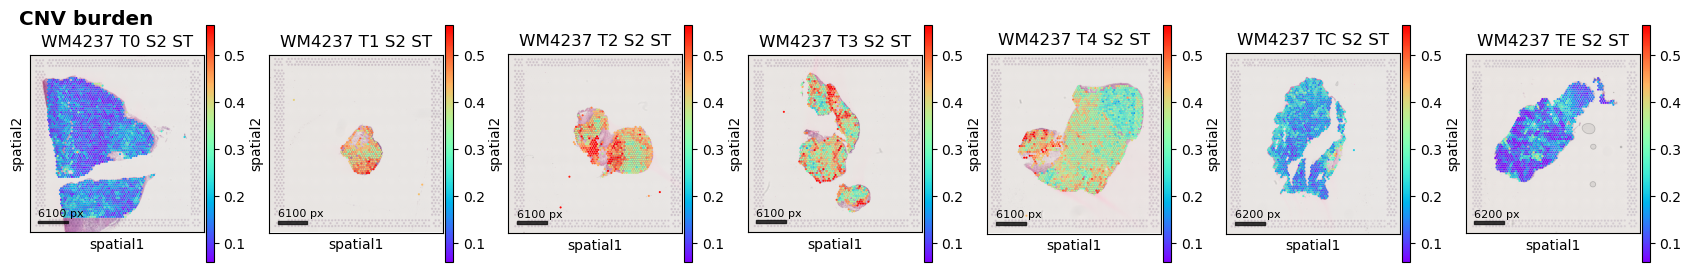

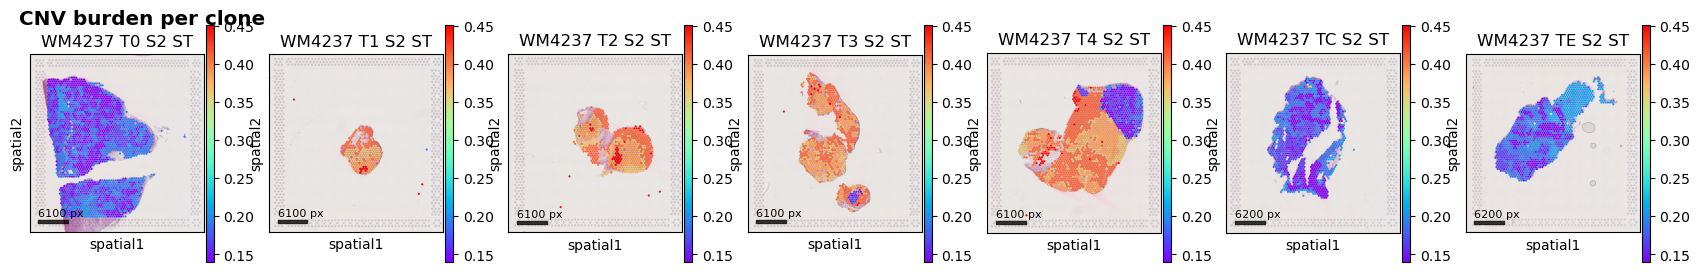

In [8]:
plotSpatialAll(ads, ids=[id for id in ids if '_S2_' in id], identity='CNV burden', palette=palette1, f=0.75, fy=1.025, nx=7, panelSize=4, wspace = 0.25, hspace = 0.2)
plotSpatialAll(ads, ids=[id for id in ids if '_S2_' in id], identity='CNV burden per clone', palette=palette1, f=0.75, fy=1.025, nx=7, panelSize=4, wspace = 0.25, hspace = 0.2)

C:\Users\domans\Anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


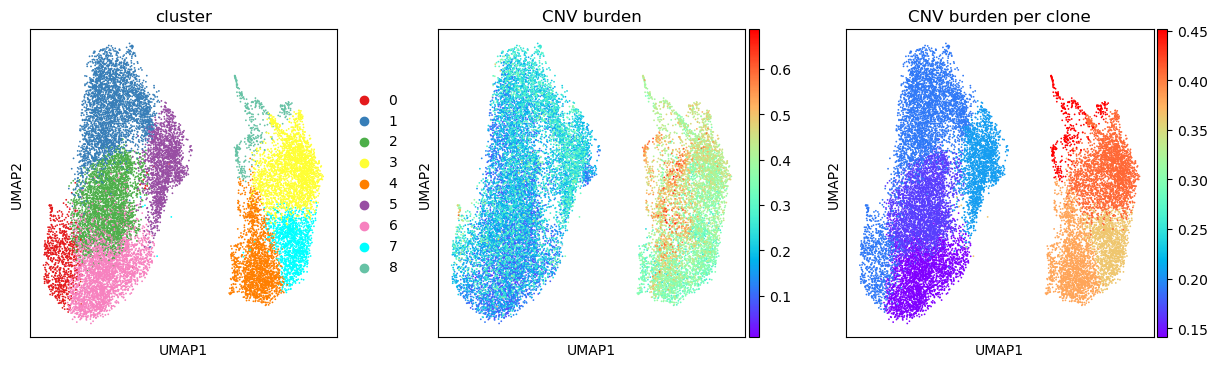

In [9]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ad_all, color=['cluster', 'CNV burden', 'CNV burden per clone'], palette=palette1, cmap='rainbow')

In [10]:
def plotOneTimePoint(df, df_meta, timePoint, random_seed=42, sample=None, reference={'time': 'T0', 'cluster':'6'}, label=''):
    
    np.random.seed(random_seed)
    
    if not sample is None:
        df_meta_temp = df_meta[df_meta['time']==timePoint].sample(sample, axis=0).astype(str)[['time', 'cluster']].sort_values(by=['time', 'cluster'], ascending=False)
    else:
        df_meta_temp = df_meta[df_meta['time']==timePoint].astype(str)[['time', 'cluster']].sort_values(by=['time', 'cluster'], ascending=False)
        
    df_temp = df[df_meta_temp.index]
    try:
        df_temp = df_temp.droplevel(['sample', 'cluster', 'time'], axis=1)
    except:
        pass

    res = cplot(df_temp, df_meta_temp, sampleMED=1000, figsize=(10, 8),
                palette=palette1, clusterVar=False, clusterObs=True, addLinesOnHeatmap=True, addLinesOnGroups=False, useMEDforObsGroups=True,
                reference=reference, colorbarLabel='%sCNV' % label, colorbarLabels=['Ampl.', 'Del.'])

    return

In [11]:
wh = df_infercnv_meta['time']=='T1'
df_infercnv_cnv_c = df_infercnv_cnv.loc[:, wh.values]
df_infercnv_meta_c = df_infercnv_meta.loc[wh.values]

After filtering: (8897, 479)
Calculating sMED metric by groups.
Subsampling each group to have at most 1000 observations.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.32s/it]


Root not found
Could not add reference label
'T0'


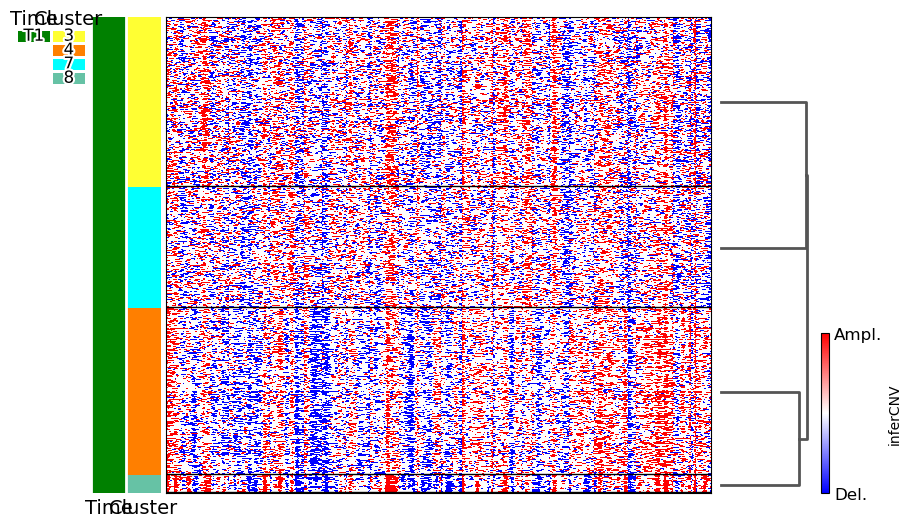

In [12]:
plotOneTimePoint(df_infercnv_cnv_c, df_infercnv_meta_c, 'T1', label='infer')

In [13]:
def remove_up_to(ins, n=50):
    
    s = ins.copy()
    
    t = s - np.roll(s.values, -1)
    a = np.where(t[:-1]==1)[0]
    b = a + 1
    t = s - np.roll(s.values, 1)
    a = np.where(t[:-1]==1)[0]
    a = a[:len(b)]
    b = b[:len(a)]
    b -= a
    
    for i, l in np.vstack([a, b]).T:
        if l<=n:
            s[i: i+l] = 0

    return s

st = pd.Series([1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0])
st1 = remove_up_to(st)
print(st.values.tolist())
print(st1.values.tolist())

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
f = lambda s: remove_up_to(s, 100)

df_infercnv_cnv_pos = df_infercnv_cnv_c.copy()
df_infercnv_cnv_pos[df_infercnv_cnv_pos < 0] = 0
df_infercnv_cnv_pos = df_infercnv_cnv_pos.apply(f, axis=0)

df_infercnv_cnv_neg = df_infercnv_cnv_c.copy()
df_infercnv_cnv_neg[df_infercnv_cnv_neg > 0] = 0
df_infercnv_cnv_neg *= -1
df_infercnv_cnv_neg = df_infercnv_cnv_neg.apply(f, axis=0)
df_infercnv_cnv_neg *= -1

df_infercnv_cnv1 = df_infercnv_cnv_pos + df_infercnv_cnv_neg

After filtering: (8897, 479)
Calculating sMED metric by groups.
Subsampling each group to have at most 1000 observations.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


Root not found
Could not add reference label
'T0'


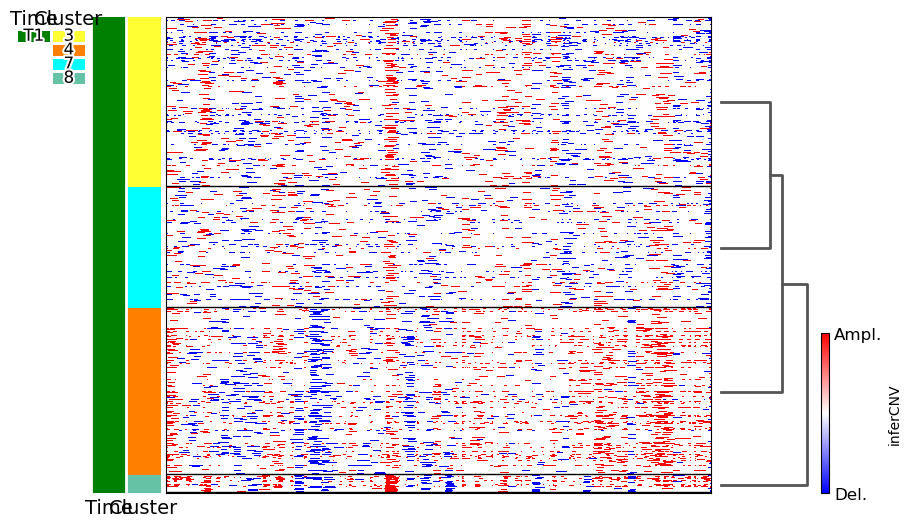

In [15]:
plotOneTimePoint(df_infercnv_cnv1, df_infercnv_meta_c, 'T1', label='infer')

In [16]:
se = pd.Series(index=pd.MultiIndex.from_frame(df_infercnv_meta_c).droplevel(0), data=(df_infercnv_cnv1!=0).mean(axis=0).values)
se.groupby(level=[0,1]).mean().unstack().fillna(0).style.background_gradient(axis=None).applymap(lambda x: 'background-color: transparent' if x==0 else '').applymap(lambda x: 'color: transparent' if x==0 else '')

time,T1
cluster,
3,0.129943
4,0.146499
7,0.104791
8,0.220193


In [17]:
f = lambda s: remove_up_to(s, 100)

df_infercnv_cnv_pos = df_infercnv_cnv.copy()
df_infercnv_cnv_pos[df_infercnv_cnv_pos < 0] = 0
df_infercnv_cnv_pos = df_infercnv_cnv_pos.apply(f, axis=0)

df_infercnv_cnv_neg = df_infercnv_cnv.copy()
df_infercnv_cnv_neg[df_infercnv_cnv_neg > 0] = 0
df_infercnv_cnv_neg *= -1
df_infercnv_cnv_neg = df_infercnv_cnv_neg.apply(f, axis=0)
df_infercnv_cnv_neg *= -1

df_infercnv_cnv2 = df_infercnv_cnv_pos + df_infercnv_cnv_neg
del df_infercnv_cnv_pos, df_infercnv_cnv_neg

In [18]:
print(model)
se = pd.Series(index=pd.MultiIndex.from_frame(df_infercnv_meta).droplevel(0), data=(df_infercnv_cnv2!=0).mean(axis=0).values)
se.groupby(level=[0,1]).mean().unstack().fillna(0).style.background_gradient(axis=None).applymap(lambda x: 'background-color: transparent; color: transparent' if x==0 else '')

WM4237


time,T0,T1,T2,T3,T4,TC,TE
cluster,,,,,,,
0,0.041530,0.000000,0.000000,0.278184,0.138524,0.070913,0.056117
1,0.030595,0.000000,0.000000,0.000000,0.101161,0.060409,0.034269
2,0.021296,0.000000,0.000000,0.195955,0.091306,0.041078,0.012325
3,0.000000,0.129943,0.196530,0.223891,0.184579,0.000000,0.000000
4,0.000000,0.146499,0.206982,0.218612,0.185038,0.000000,0.000000
5,0.032191,0.000000,0.078397,0.000000,0.096409,0.067660,0.047510
6,0.011638,0.000000,0.000000,0.187498,0.079126,0.036881,0.010447
7,0.000000,0.104791,0.161197,0.178546,0.168433,0.021805,0.000000
8,0.000000,0.220193,0.302946,0.316897,0.292893,0.000000,0.000000


In [19]:
print(model)
se.groupby(level=[0]).mean().to_frame().T.style.background_gradient(axis=None)

WM4237


cluster,0,1,2,3,4,5,6,7,8
0,0.053882,0.038624,0.030512,0.194400,0.197665,0.049762,0.024302,0.163117,0.298205


In [20]:
se.groupby(level=[0]).mean().to_frame().style.background_gradient(axis=None)

,0
cluster,
0,0.053882
1,0.038624
2,0.030512
3,0.194400
4,0.197665
5,0.049762
6,0.024302
7,0.163117
8,0.298205


After filtering: (8897, 18387)
Calculating sMED metric by groups.
Subsampling each group to have at most 100 observations.


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [04:54<00:00,  7.75s/it]


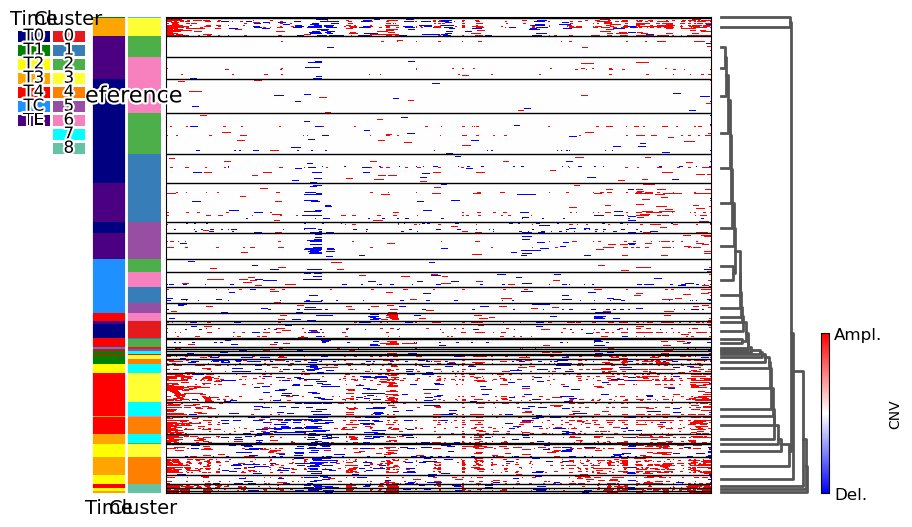

In [21]:
df_meta_temp = df_infercnv_meta.astype(str)[['time', 'cluster']].sort_values(by=['time', 'cluster'], ascending=False)
df_temp = df_infercnv_cnv2[df_meta_temp.index]
cplot(df_temp, df_meta_temp, sampleMED=100, figsize=(10, 8),
    palette=palette1, clusterVar=False, clusterObs=True, addLinesOnHeatmap=True, addLinesOnGroups=False, useMEDforObsGroups=True,
    reference={'time': 'T0', 'cluster':'6'}, colorbarLabel='%sCNV' % '', colorbarLabels=['Ampl.', 'Del.']);

After filtering: (8897, 18387)
Calculating sMED metric by groups.
Subsampling each group to have at most 100 observations.


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [04:34<00:00,  7.21s/it]


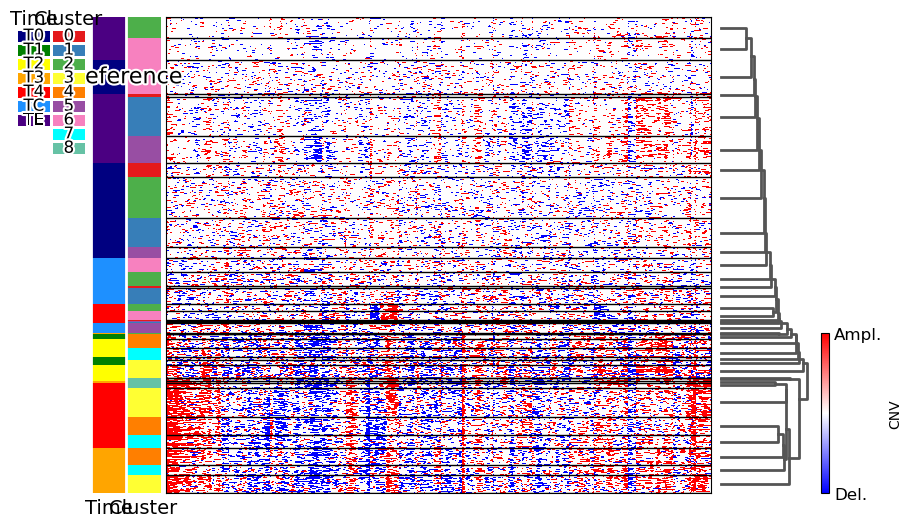

In [22]:
df_meta_temp = df_infercnv_meta.astype(str)[['time', 'cluster']].sort_values(by=['time', 'cluster'], ascending=False)
df_temp = df_infercnv_cnv[df_meta_temp.index]
cplot(df_temp, df_meta_temp, sampleMED=100, figsize=(10, 8),
    palette=palette1, clusterVar=False, clusterObs=True, addLinesOnHeatmap=True, addLinesOnGroups=False, useMEDforObsGroups=True,
    reference={'time': 'T0', 'cluster':'6'}, colorbarLabel='%sCNV' % '', colorbarLabels=['Ampl.', 'Del.']);

In [23]:
cnv_obs = sc.read(dataPath + 'ad_all_human_clustered_cnv_%s.h5ad' % model).obs[['cnv_clusters']].rename({'cnv_clusters': 'cnv_cluster'}, axis=1)
df_infercnv_meta2 = df_infercnv_meta.copy()
df_infercnv_meta2['cnv_cluster'] = cnv_obs.reindex(df_infercnv_meta.index).astype(str)
df_infercnv_meta2

,sample,cluster,time,cnv_cluster
spot,,,,
ATAATCTTGGAGAACC-1-WM4237_T0_S1_ST,T0_S1,6,T0,0
ACGGCTGGATGTAGAA-1-WM4237_T0_S1_ST,T0_S1,6,T0,0
TCCGACCGCTAATCAA-1-WM4237_T0_S1_ST,T0_S1,6,T0,0
CGGCTCTTCGTCGAAC-1-WM4237_T0_S1_ST,T0_S1,6,T0,0
GAGGTCCGTTCGCTGT-1-WM4237_T0_S1_ST,T0_S1,6,T0,0
...,...,...,...,...
ATCCTGCGTGGAATGG-1-WM4237_TE_S4_ST,TE_S4,6,TE,1
CCATCGCAGTTAAACT-1-WM4237_TE_S4_ST,TE_S4,6,TE,2
CAGGATATATCGTTGT-1-WM4237_TE_S4_ST,TE_S4,6,TE,1


After filtering: (8897, 18328)
Calculating sMED metric by groups.
Subsampling each group to have at most 100 observations.


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [09:10<00:00,  9.17s/it]


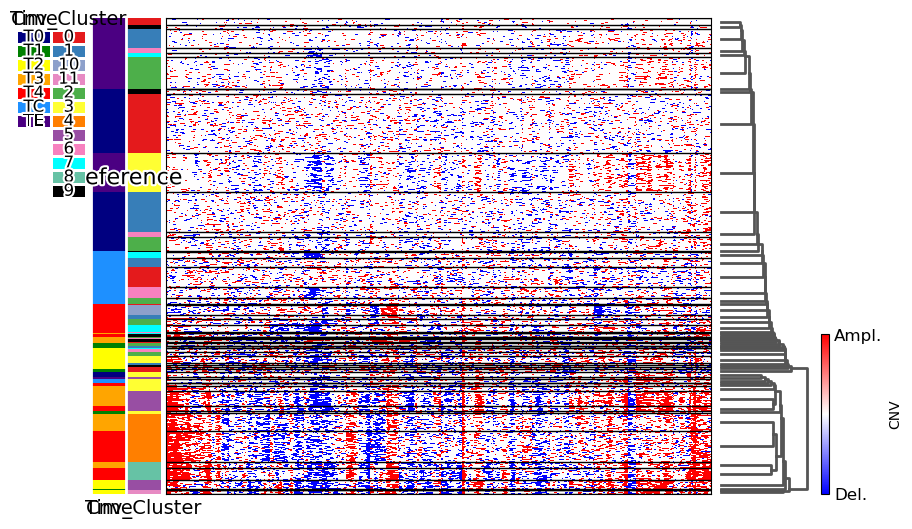

In [24]:
df_meta_temp = df_infercnv_meta2.astype(str)[['time', 'cnv_cluster']].sort_values(by=['time', 'cnv_cluster'], ascending=False)
df_temp = df_infercnv_cnv[df_meta_temp.index]
cplot(df_temp, df_meta_temp, sampleMED=100, figsize=(10, 8),
    palette=palette1, clusterVar=False, clusterObs=True, addLinesOnHeatmap=True, addLinesOnGroups=False, useMEDforObsGroups=True,
    reference={'time': 'T0'}, colorbarLabel='%sCNV' % '', colorbarLabels=['Ampl.', 'Del.']);

After filtering: (8897, 18328)
Calculating sMED metric by groups.
Subsampling each group to have at most 100 observations.


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [09:21<00:00,  9.36s/it]


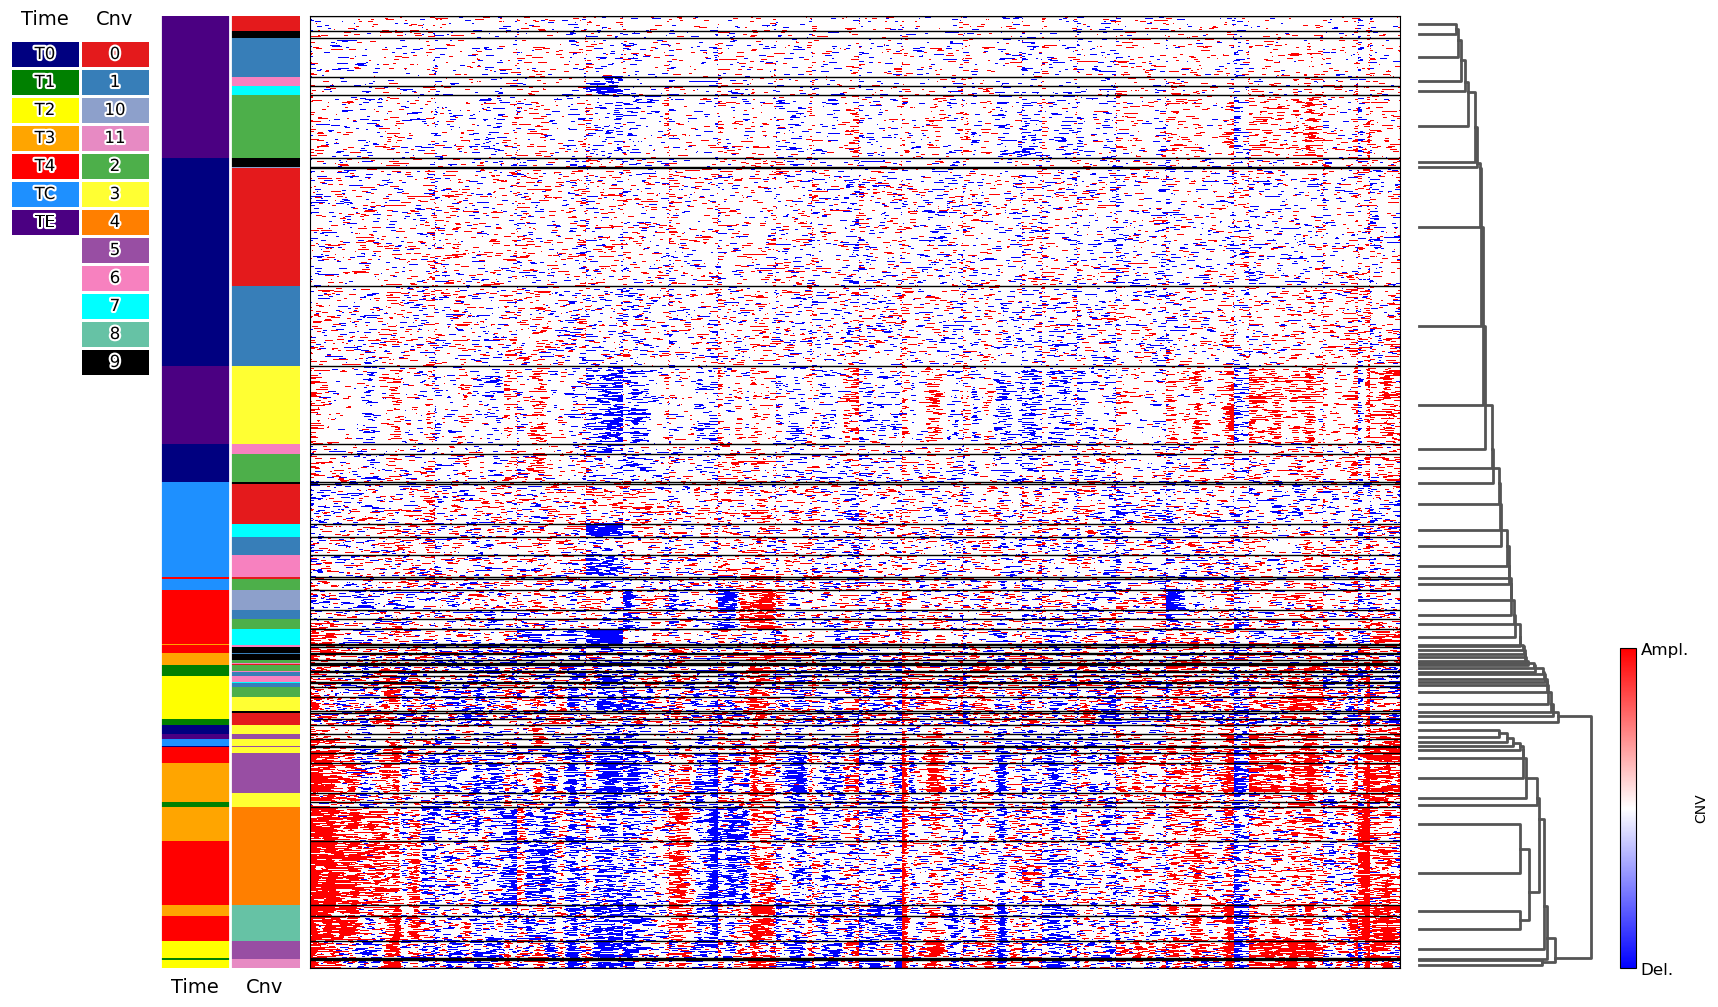

In [25]:
df_meta_temp = df_infercnv_meta2.astype(str)[['time', 'cnv_cluster']].sort_values(by=['time', 'cnv_cluster'], ascending=False).rename({'cnv_cluster': 'CNV'}, axis=1)
df_temp = df_infercnv_cnv[df_meta_temp.index]
cplot(df_temp, df_meta_temp, sampleMED=100, figsize=(20, 16),
    palette=palette1, clusterVar=False, clusterObs=True, addLinesOnHeatmap=True, addLinesOnGroups=False, useMEDforObsGroups=True,
    reference=dict(), colorbarLabel='%sCNV' % '', colorbarLabels=['Ampl.', 'Del.']);

After filtering: (8897, 18328)
Calculating sMED metric by groups.
Subsampling each group to have at most 100 observations.


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [08:50<00:00,  8.85s/it]


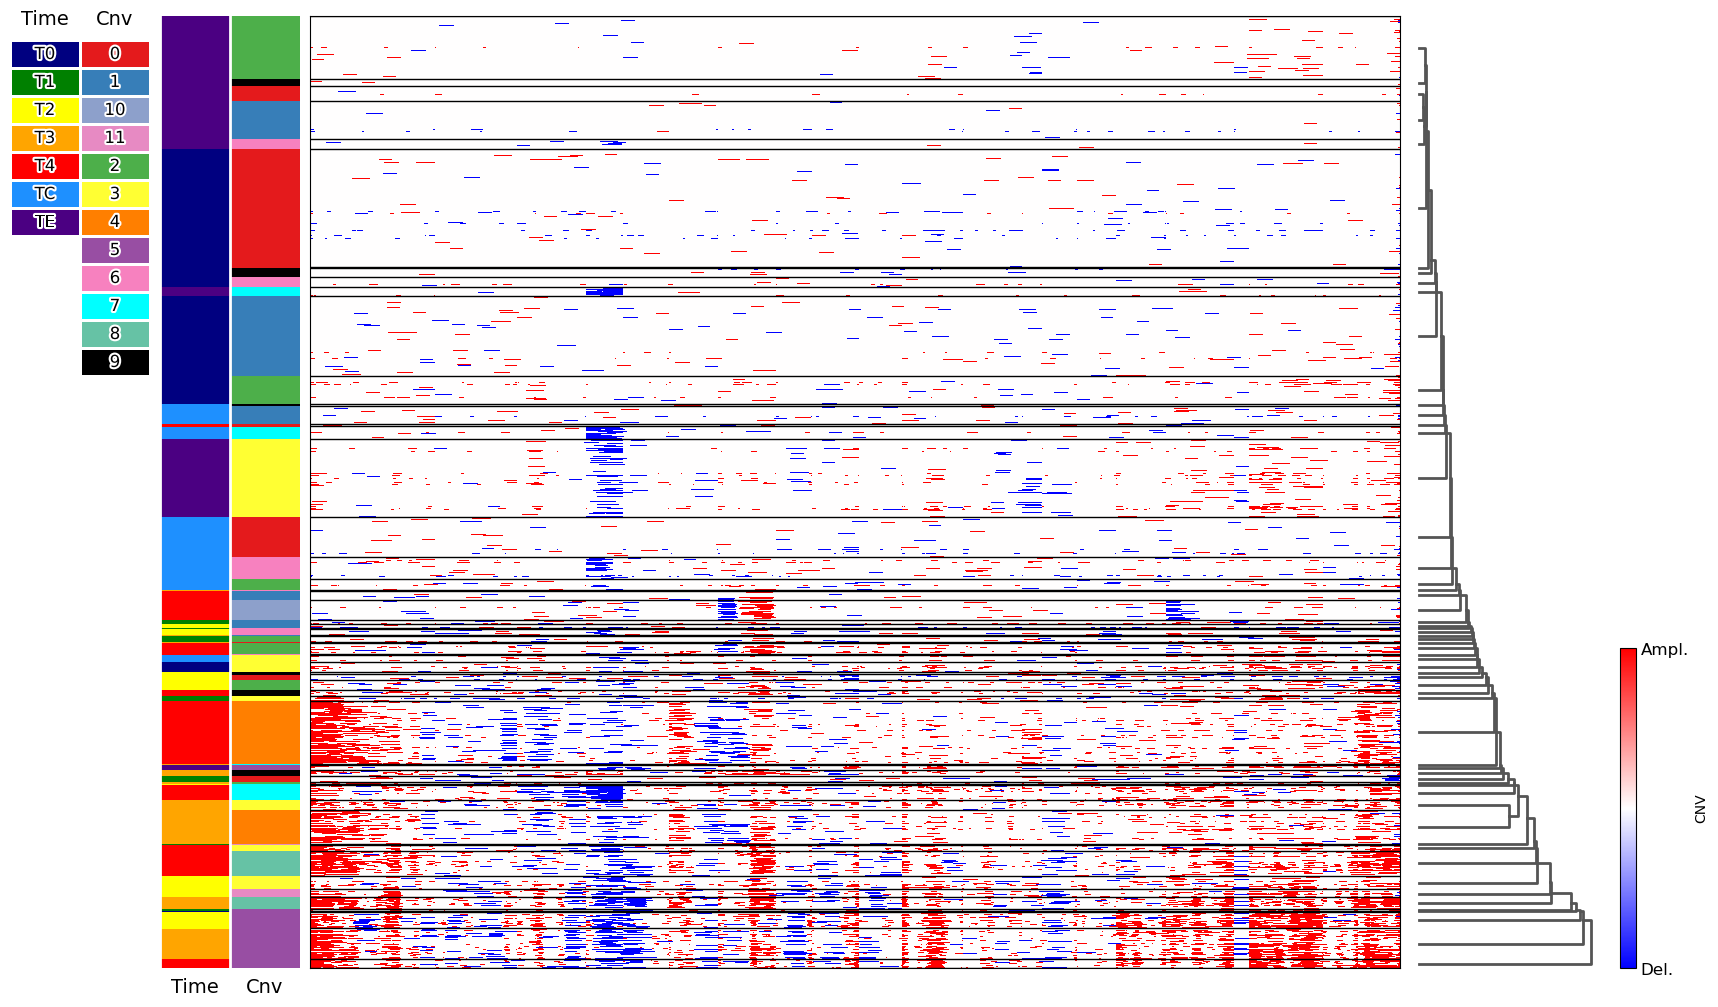

In [26]:
df_meta_temp = df_infercnv_meta2.astype(str)[['time', 'cnv_cluster']].sort_values(by=['time', 'cnv_cluster'], ascending=False).rename({'cnv_cluster': 'CNV'}, axis=1)
df_temp = df_infercnv_cnv2[df_meta_temp.index]
cplot(df_temp, df_meta_temp, sampleMED=100, figsize=(20, 16),
    palette=palette1, clusterVar=False, clusterObs=True, addLinesOnHeatmap=True, addLinesOnGroups=False, useMEDforObsGroups=True,
    reference=dict(), colorbarLabel='%sCNV' % '', colorbarLabels=['Ampl.', 'Del.']);